### Basic data analysis or exploratory data analysis (EDA)

In [2]:
!pip install --upgrade seaborn pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import boto3
import io
from io import StringIO
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sagemaker
import joblib
import tarfile
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# dataset 의 로드 index  이름 없는 데이터 드랍 
training_data = pd.read_csv('./data/cs-training.csv')
training_data = training_data.drop('Unnamed: 0', axis = 1)


# 헤더 네임 - 제거 
cleancolumn = []
for i in range(len(training_data.columns)):
    cleancolumn.append(training_data.columns[i].replace('-', '').lower())
training_data.columns = cleancolumn

###  DATA 속성의 의미

- SeriousDlqin2yrs : 향후 2년 동안 심각한 연체 기록이 있는지
- RevolvingUtilizationOfUnsecuredLines : 신용카드와 개인 신용 한도의 사용 비율
- NumberOfTime30-59DaysPastDueNotWorse : 30일에서 59일 사이 연체된 적이 몇 번 있는지
- DebtRatio : 월 소득 비 부채 비율 
- MonthlyIncome : 월 수입


In [5]:
# Null 값 ( = 누락된 데이터) ~> 중앙값을 대체
# training_data[training_data.columns[1:]].median()
# Null 값 ( = 누락된 데이터) ~> 평균값을 대체 
# training_data[training_data.columns[1:]].mean()

In [6]:
# 타겟 레아블 percentage


total = len(training_data) 
numberOfIsSeriousDlqin2yrs = training_data['seriousdlqin2yrs'].value_counts() #지난 2년 동안 심각한 연체 기록이 있는 사람 수 

percentage_labels = (numberOfIsSeriousDlqin2yrs/total)*100 #지난 2년 동안 심각한 연체 기록이 있는 사람 비율 


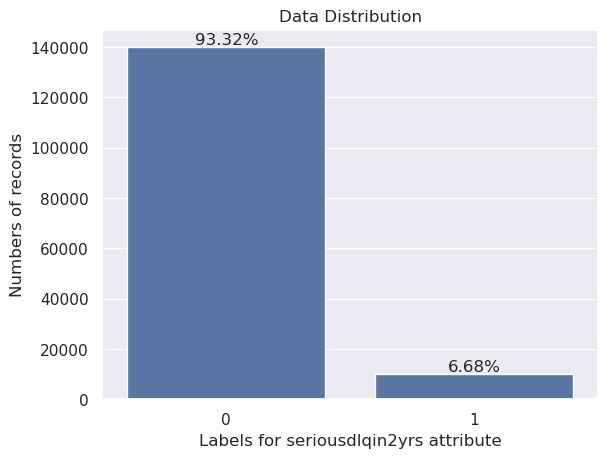

In [7]:
#지난 2년 동안 심각한 연체 기록이 있는 사람 비율 그리기 
sns.set()

# sns.countplot을 호출할 때 'x'와 'data'를 키워드 인자로 사용
sns.countplot(x='seriousdlqin2yrs', data=training_data).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    # total_len을 계산하기 위해 len() 함수를 사용
    total_len = len(training_data['seriousdlqin2yrs'])
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100 * (height / total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=0.5)
ax.set_xlabel("Labels for seriousdlqin2yrs attribute")
ax.set_ylabel("Numbers of records")
plt.show()


### Missing values

In [8]:
# None 처리 된 데이터가 몇개 있는지 확인
numberOfNullData = training_data.isnull().sum()

In [9]:
# None 처리된 비율 그리기
# ---------------

# x = training_data.columns
# y = numberOfNullData

# sns.set()
# sns.barplot(y)

# ax = plt.gca()

# for p in ax.patches:
#     height = p.get_height()
#     ax.text(p.get_x() + p.get_width()/2.,
#             height + 2,
#             int(height),
#             fontsize=14, ha='center', va='bottom')
# sns.set(font_scale=1.5)

# ax.set_xlabel("Data Attributes")
# ax.set_ylabel("count of missing records for each attribute")
# plt.xticks(rotation=90)
# plt.show()

### Null 대체 

In [10]:
# Null 값 ( = 누락된 데이터) ~> 평균값을 대체 
training_data_mean_replace = training_data.fillna((training_data.mean()))
# training_data_mean_replace.head()

In [11]:
# Actual replacement of the missing value using median value.
training_data_median_replace = training_data.fillna((training_data.median()))
# training_data_median_replace.head()

In [12]:
# training_data 중앙값으로 업데이트
training_data.fillna((training_data.median()), inplace=True)

### 연관성 확인하기 
training_data.columns[1:] 는 SeriousDlqin2yrs 을 제외한 속성들 

corr() 은 상관계수 구하는 메서드 
- 1에 가까울수록 완벽한 양의 선형 관계
- -1에 가까울수록 완벽한 음의 선형 관계
- 0은 변수 간에 선형적 관계가 없음


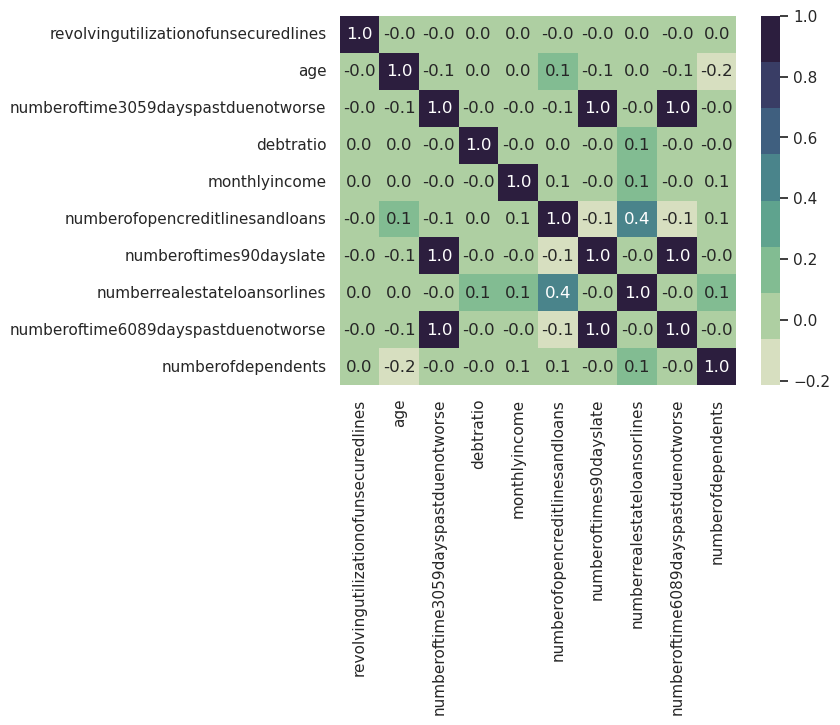

In [13]:
training_data[training_data.columns[1:]].corr()
sns.set()
sns.heatmap(training_data[training_data.columns[1:]].corr(),annot=True,fmt=".1f",
            cmap=(sns.cubehelix_palette(8, start=.5, rot=-.75)))
plt.show()

### 이상치 탐지 (신뢰도 범위 밖 데이터 처리 )

In [14]:
#  백분위(%) 기반 이상값 처리 메서드 
# --> 상위 k% , 하위 k% 는 이상치 로 판단 

# percentile_based_outlier
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))

# mad_based_outlier
def mad_based_outlier(points, thresh=3.5):
    # points를 numpy 배열로 변환
    if len(points.shape) == 1:
        points = np.array(points)[:, None]
    median_y = np.median(points, axis=0)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points], axis=0)
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
    return np.abs(modified_z_scores) > thresh

# std_div
def std_div(data, threshold=3): # threshold: 이상치로 간주되는 기준값
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

# outlierVote
def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    # zip 객체를 list로 변환
    temp = list(zip(data.index, x, y, z))
    final = []
    for item in temp:
        # item.count(False) 대신에 sum을 사용하여 False의 개수를 계산
        if sum(not flag for flag in item[1:]) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final
# std_div(data=training_data.age)
#outlierVote(data=training_data.age)

In [15]:
# 함수는 주어진 데이터셋 x에 대해 네 가지 이상치 탐지 방법을 시각적으로 비교하는 데 사용됩니다.     
def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.kdeplot(x, ax=ax, fill=True)
        sns.rugplot(x, ax=ax, color="g")
        
        # 이상치 식별
        outlier_mask = func(x)
        # 안전한 인덱싱 방법 사용
        if isinstance(outlier_mask, np.ndarray) or isinstance(outlier_mask, pd.Series):
            outliers = x.loc[outlier_mask] if isinstance(x, pd.Series) else x[outlier_mask]
            ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    # 제목 설정 및 그림 크기 조정
    set_plot_titles_and_adjust_fig_size(axes, fig, len(x))

def set_plot_titles_and_adjust_fig_size(axes, fig, n):
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(n), size=20)
    fig.set_size_inches(15, 10)


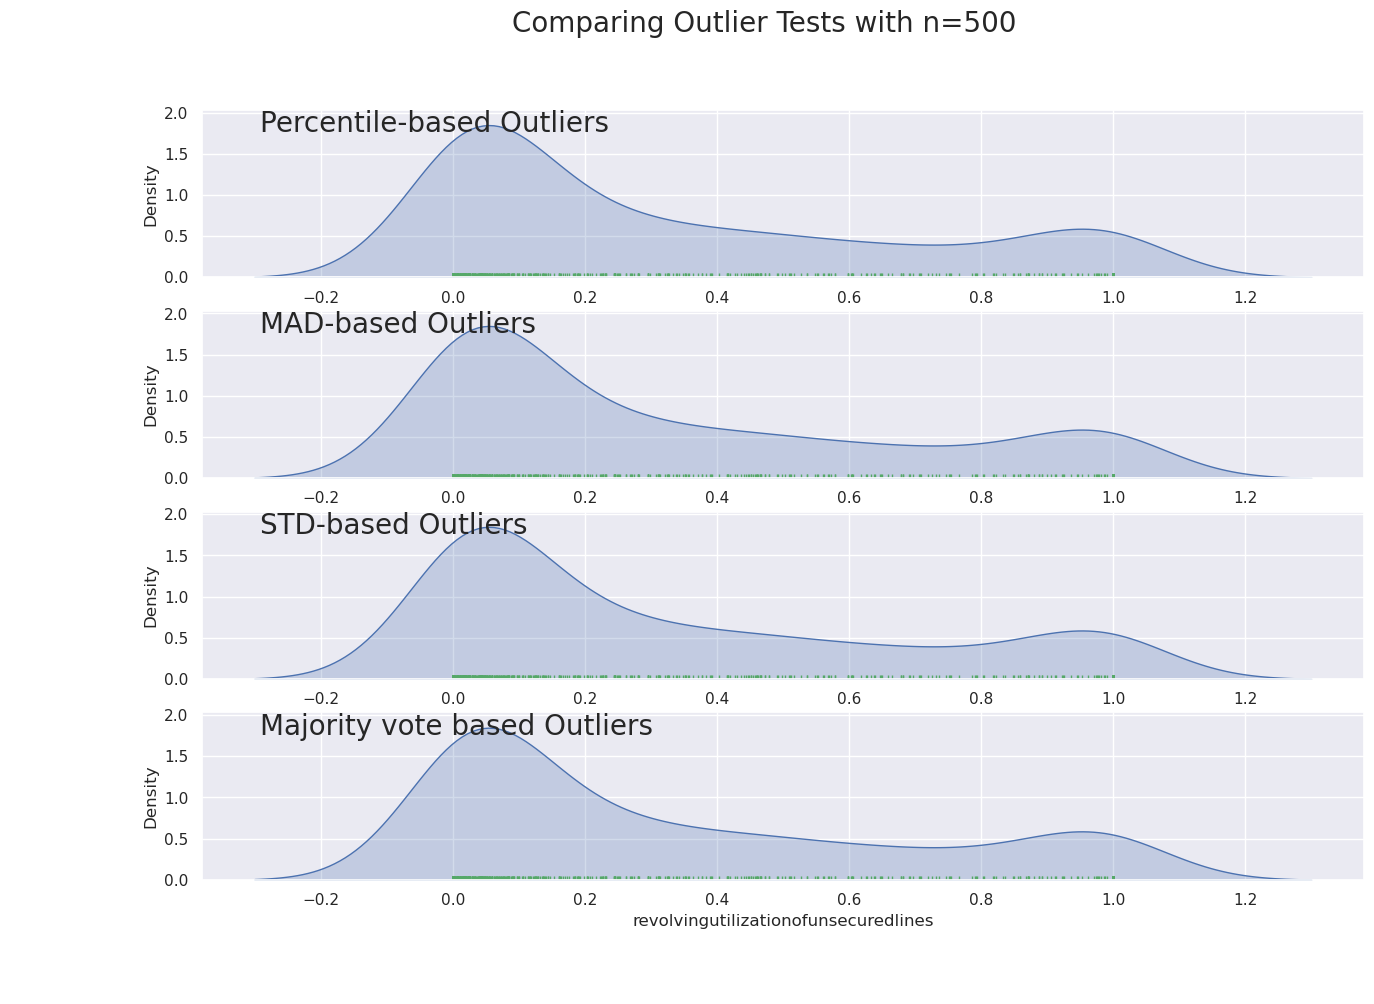

In [78]:
plotOutlier(training_data.revolvingutilizationofunsecuredlines.sample(500))

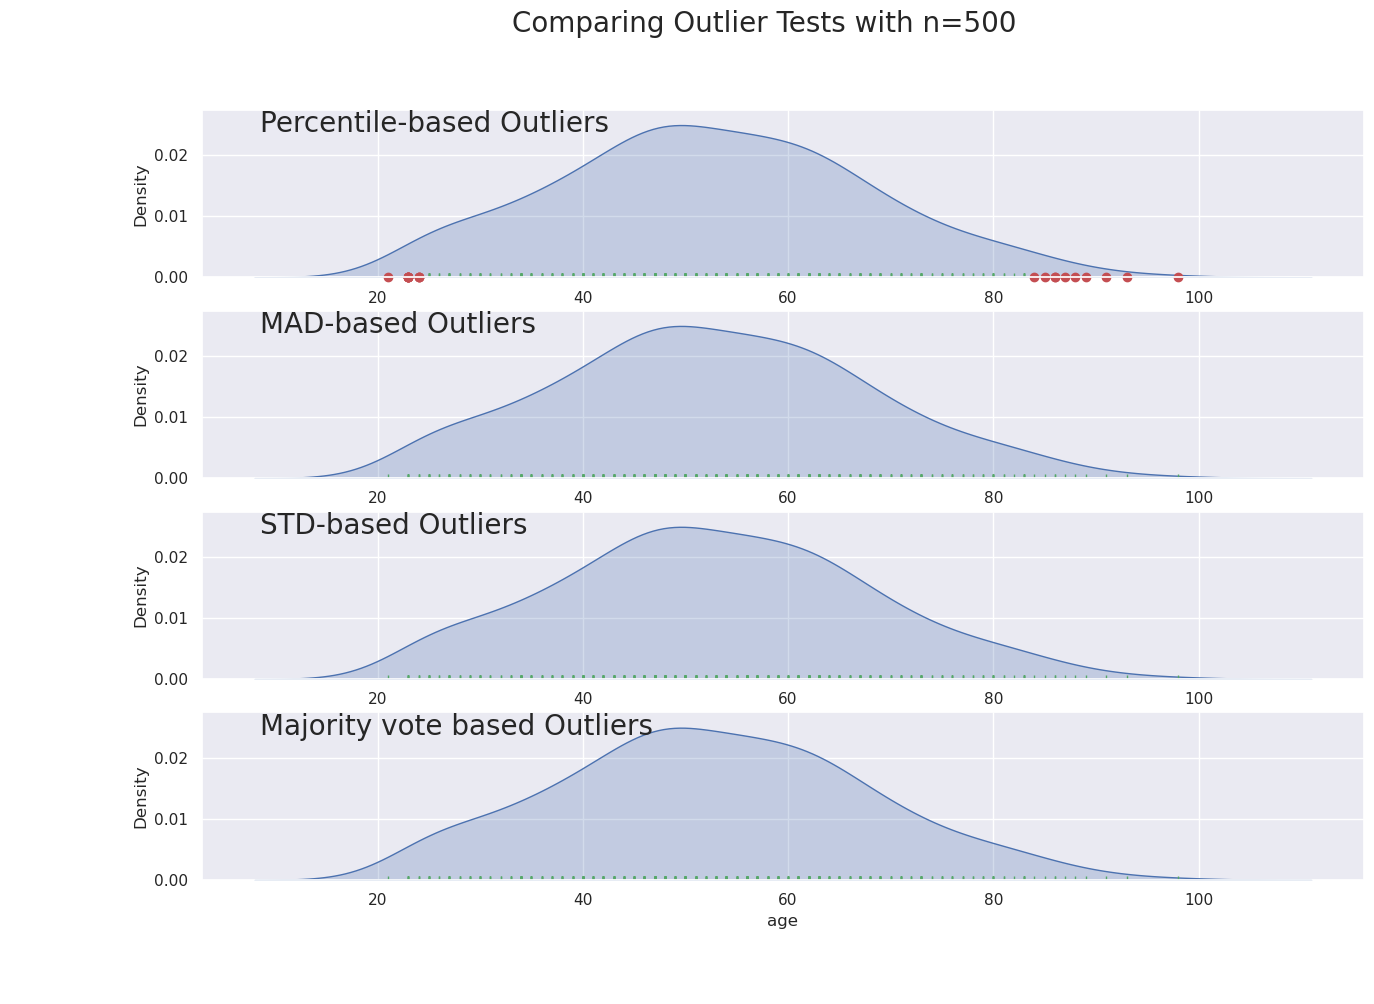

In [77]:
plotOutlier(training_data.age.sample(500))

/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


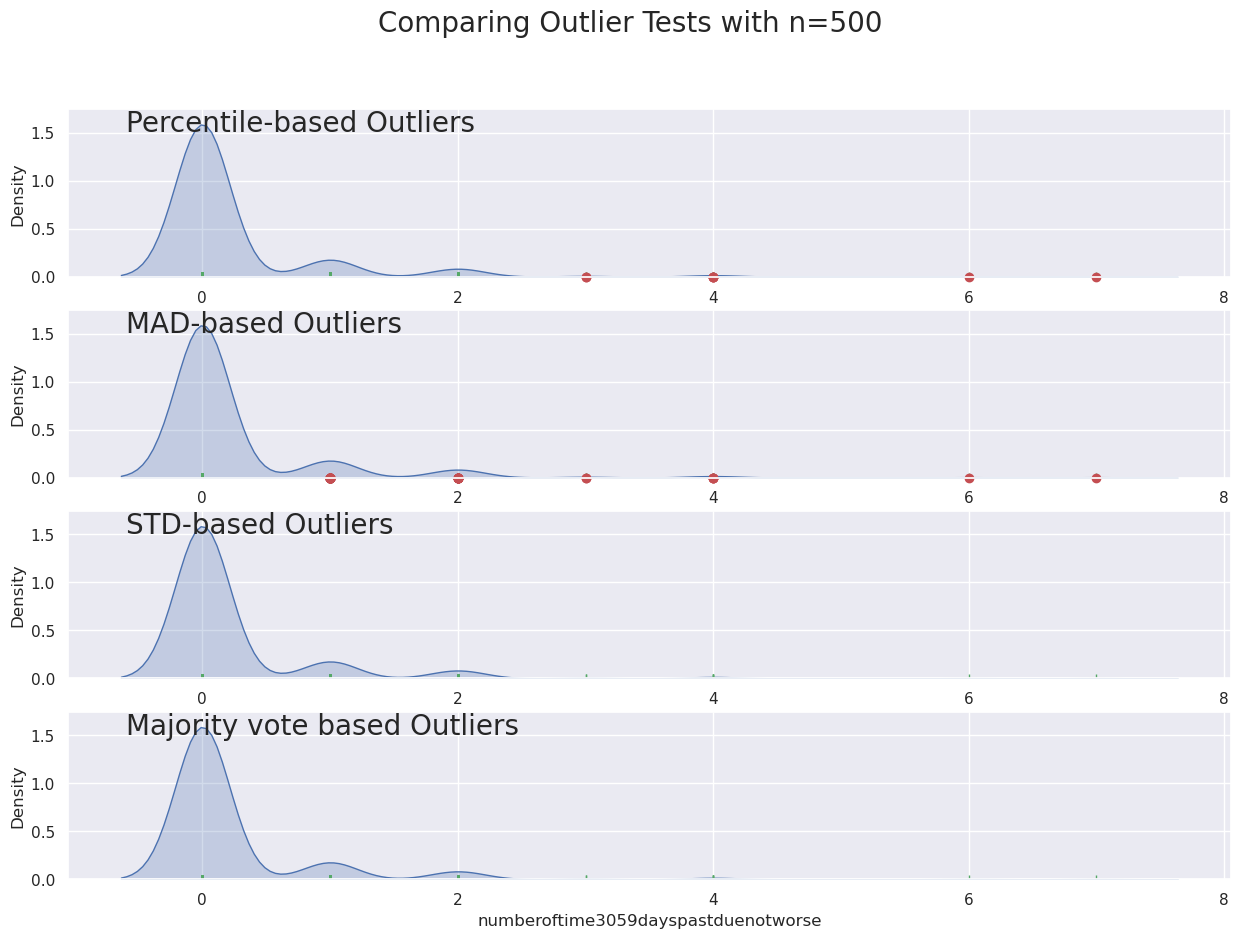

In [76]:
plotOutlier(training_data.numberoftime3059dayspastduenotworse.sample(500))

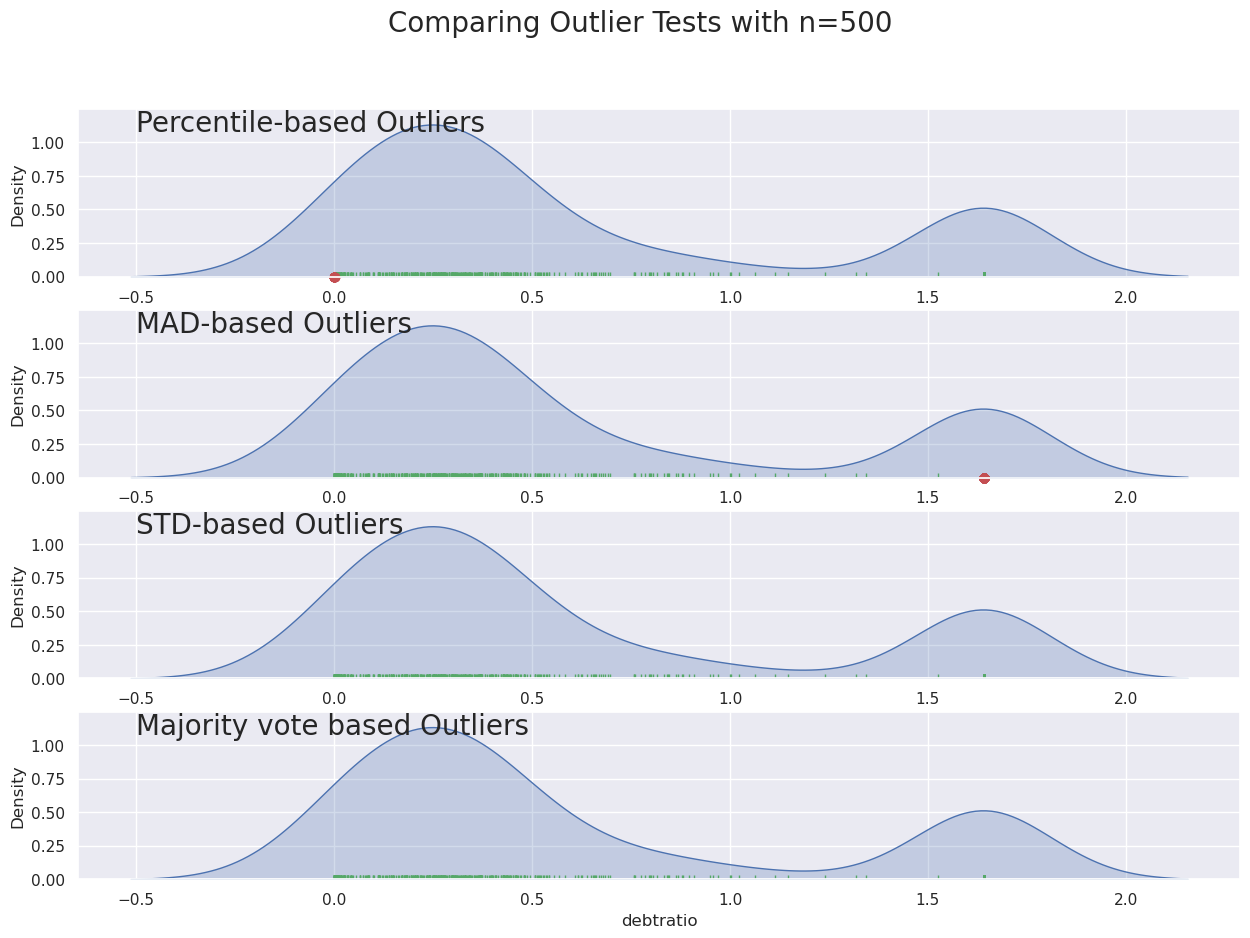

In [81]:
plotOutlier(training_data.debtratio.sample(500))

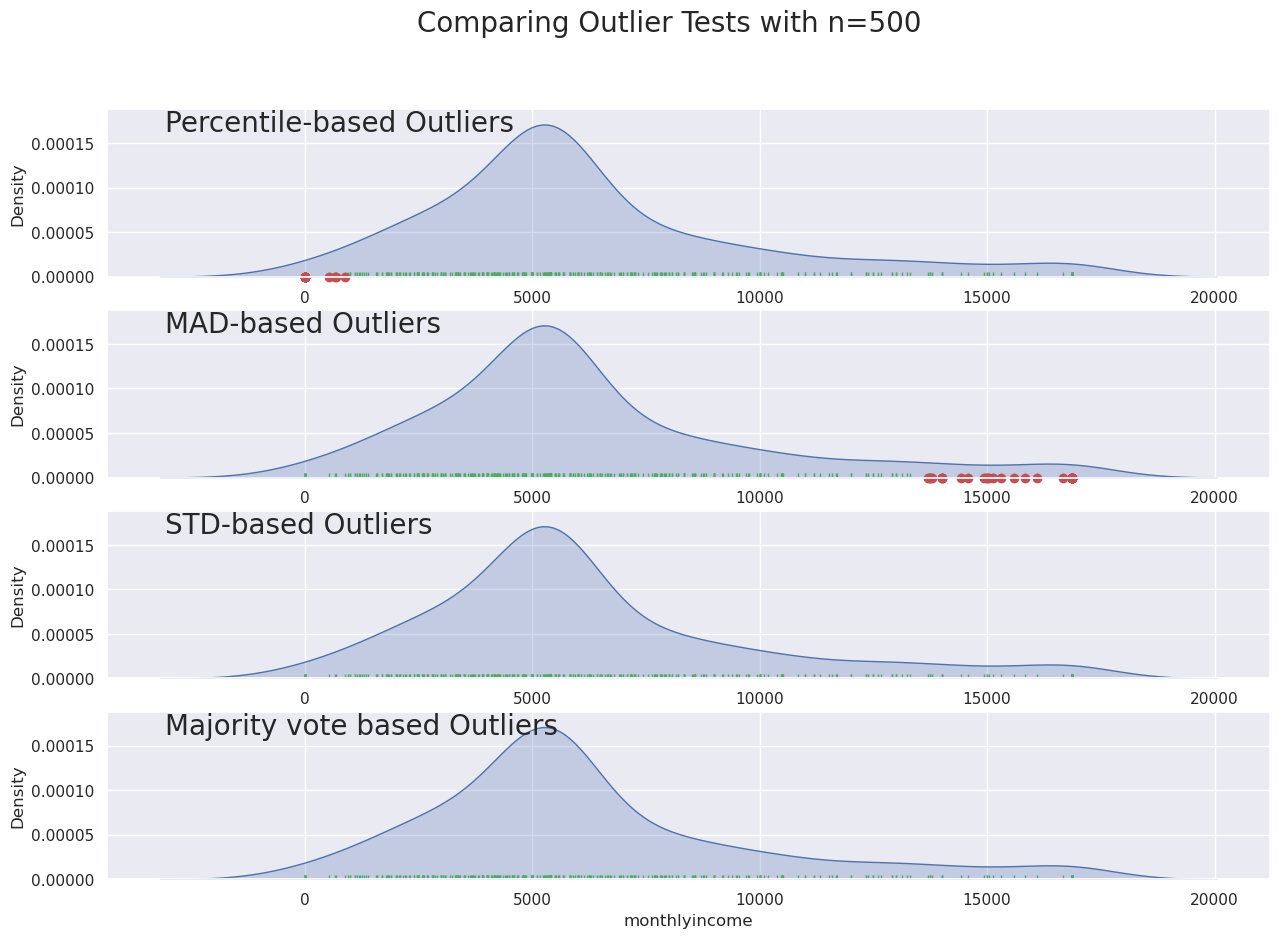

In [80]:
plotOutlier(training_data.monthlyincome.sample(500))

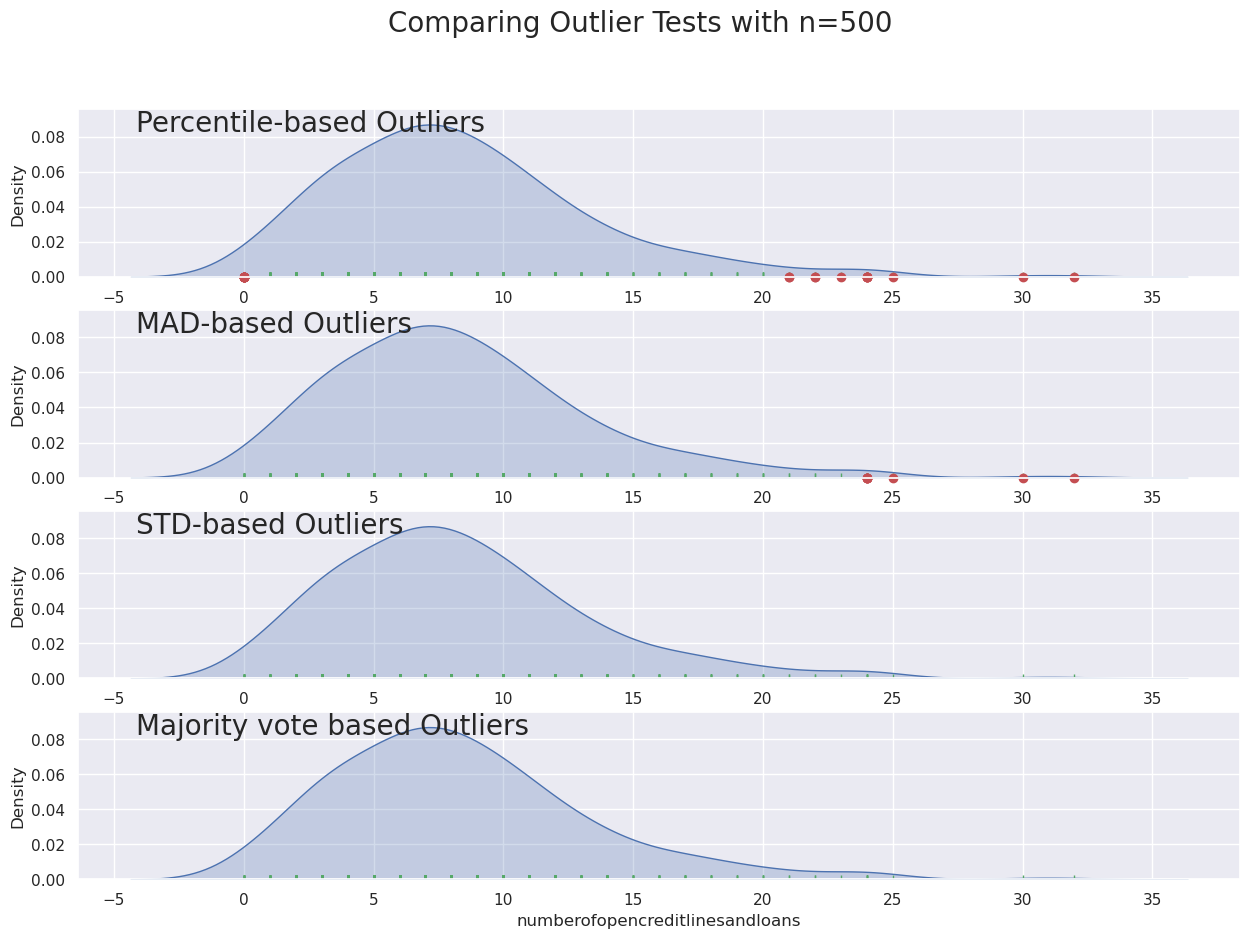

In [79]:
plotOutlier(training_data.numberofopencreditlinesandloans.sample(500))


/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


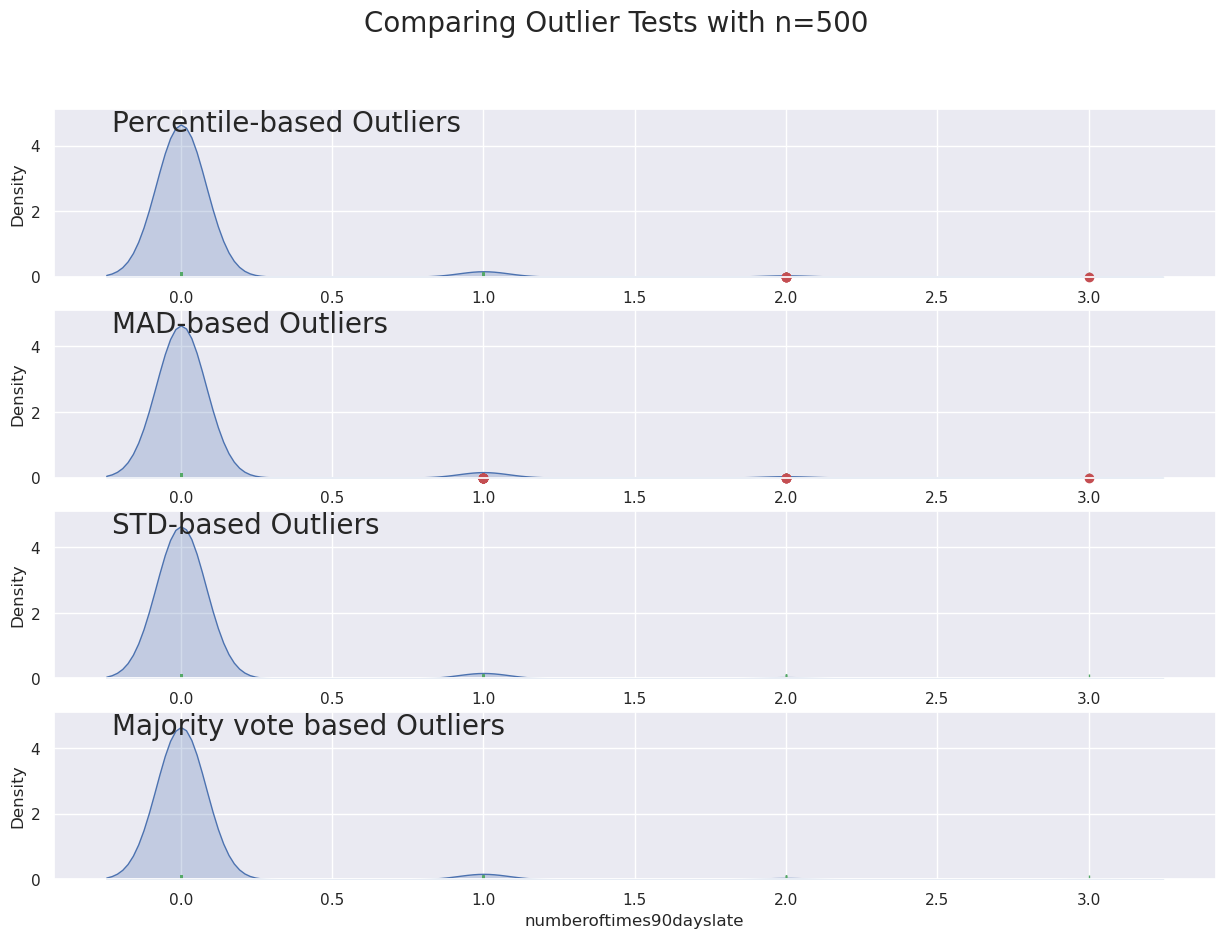

In [82]:
plotOutlier(training_data.numberoftimes90dayslate.sample(500))

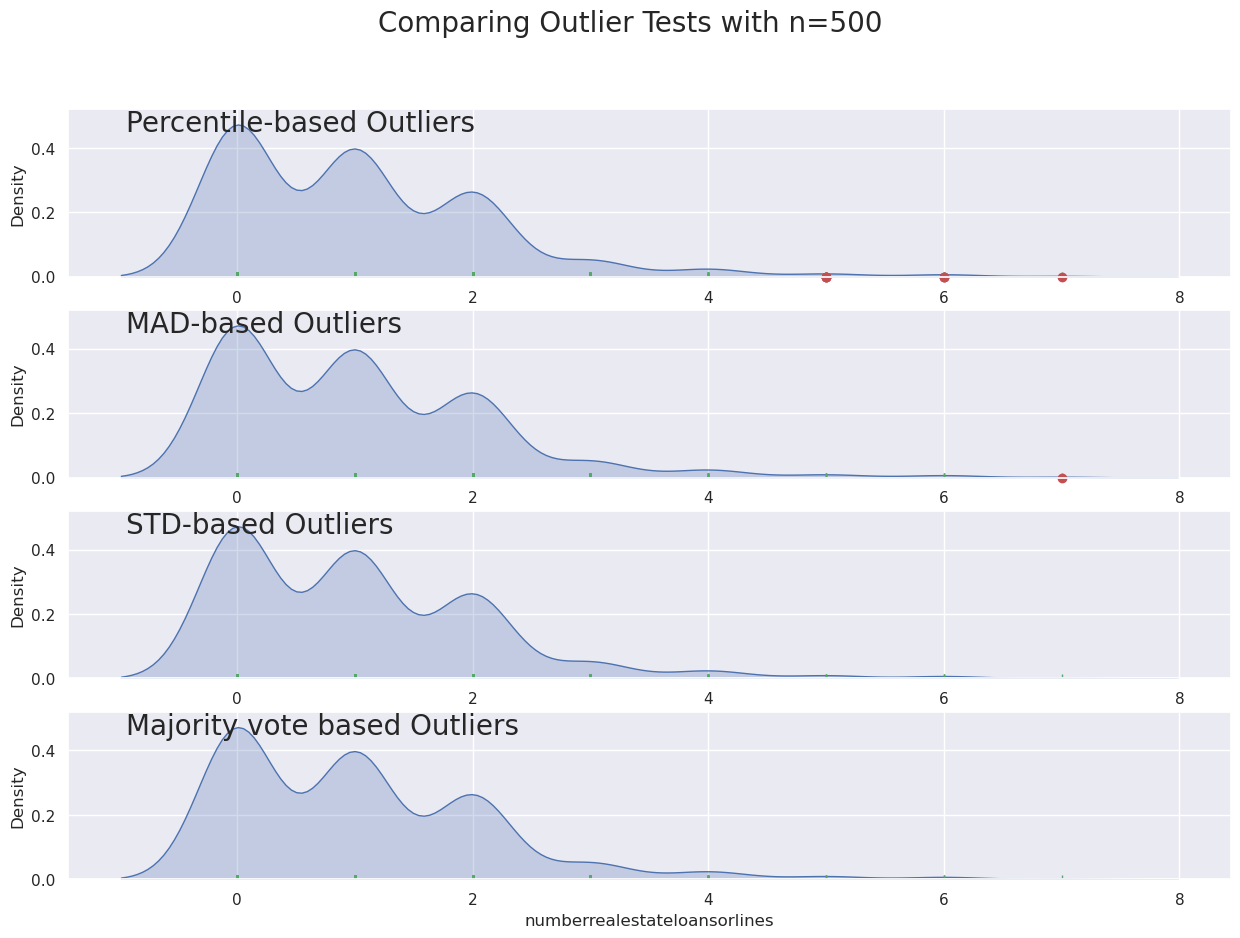

In [75]:
plotOutlier(training_data.numberrealestateloansorlines.sample(500))

/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


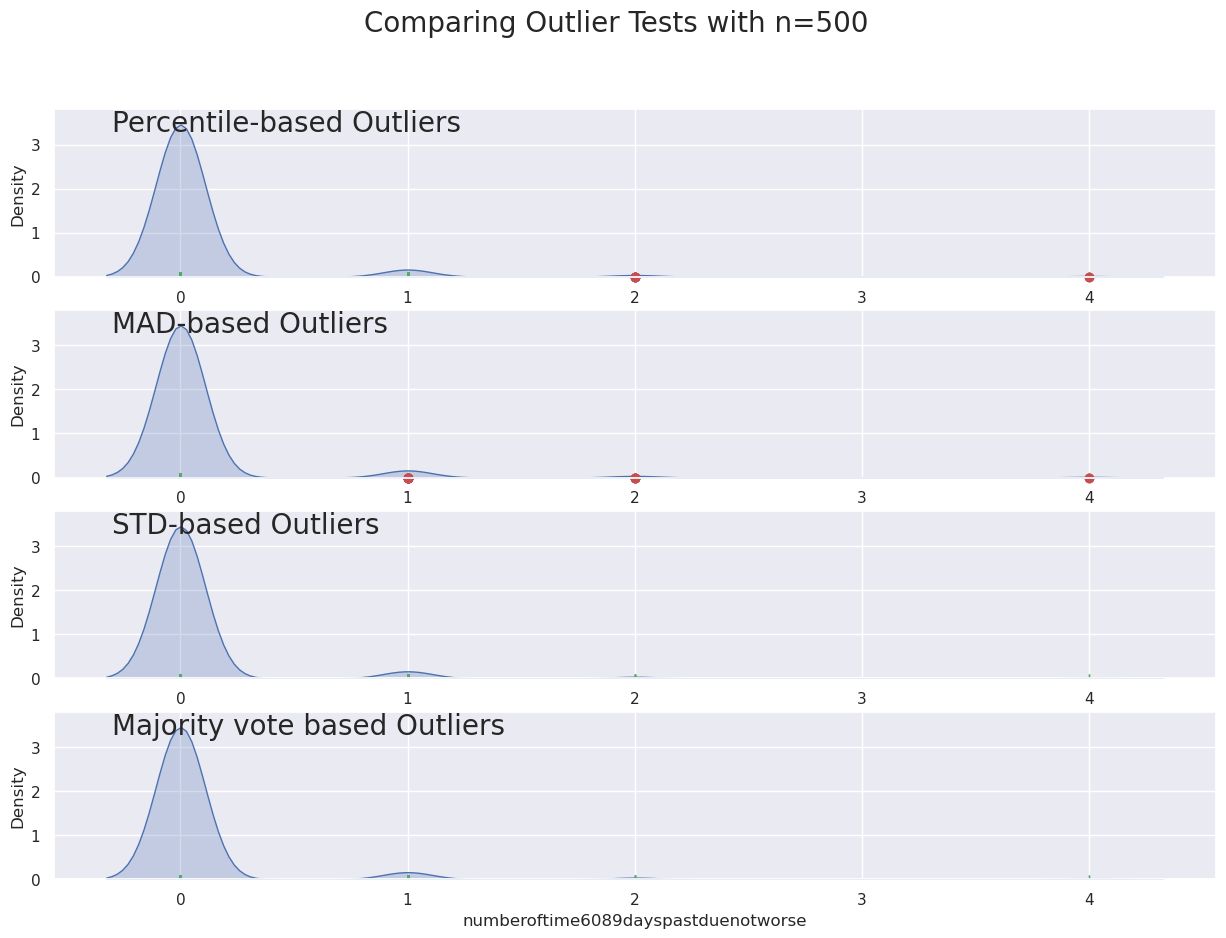

In [74]:
plotOutlier(training_data.numberoftime6089dayspastduenotworse.sample(500))

/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: divide by zero encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]
/tmp/ipykernel_1053/2391987989.py:17: RuntimeWarning: invalid value encountered in divide
  modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in points]


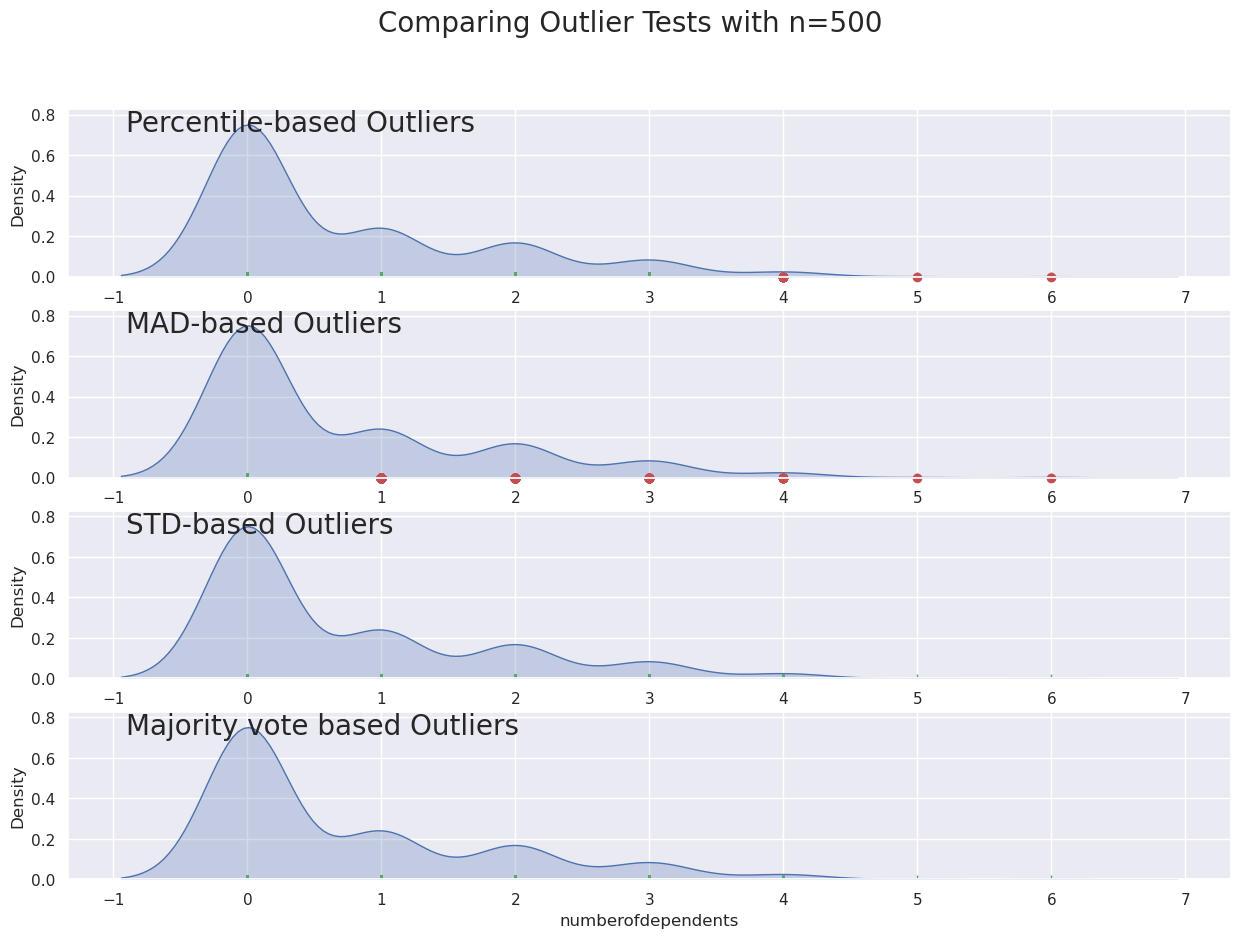

In [83]:
plotOutlier(training_data.numberofdependents.sample(500))

### 신용사용비율 상한 처리 

In [26]:
revNew = []

# training_data.revolvingutilizationofunsecuredlines 
# 신용카드와 개인 신용 한도의 사용 비율

for val in training_data.revolvingutilizationofunsecuredlines:
    if val <= 0.99999:
        revNew.append(val)
    else: # 비율 상한처리 
        revNew.append(0.99999)
        
training_data.revolvingutilizationofunsecuredlines = revNew

In [27]:
# training_data.age.plot.box()

In [28]:
# collections.Counter(training_data.age)

### 나이 하한 처리 

In [29]:
ageNew = []
for val in training_data.age:
    if val > 21:
        ageNew.append(val)
    else:
        ageNew.append(21)
        
training_data.age = ageNew

In [30]:
collections.Counter(training_data.numberoftime3059dayspastduenotworse)

Counter({0: 126018,
         1: 16033,
         2: 4598,
         3: 1754,
         4: 747,
         5: 342,
         98: 264,
         6: 140,
         7: 54,
         8: 25,
         9: 12,
         96: 5,
         10: 4,
         12: 2,
         13: 1,
         11: 1})

### 연체 횟수 특정값 처리

In [31]:
# numberoftime3059dayspastduenotworse
# 30일에서 59일 사이 연체된 적이 몇 번 있는지
New = []
med = training_data.numberoftime3059dayspastduenotworse.median()
for val in training_data.numberoftime3059dayspastduenotworse:
    if ((val == 98) or (val == 96)):
        New.append(med)
    else:
        New.append(val)

training_data.numberoftime3059dayspastduenotworse = New

In [32]:
# outlierRatio 함수는 주어진 데이터셋에 대해 네 가지 이상치 탐지 방법을 적용
# 각 방법별 이상치의 수
# 전체 이상치의 비율을 계산하여 결과를 반환

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict
outlierRatio(training_data.debtratio)

{'percentile_based_outlier': [3750, '2.50%'],
 'mad_based_outlier': [31727, '21.15%'],
 'std_div': [779, '0.52%'],
 'outlierVote': [3750, '2.50%']}

In [33]:
# plotOutlier(training_data.debtratio.sample(1000))

In [34]:
# def add_freq():
#     ncount = len(training_data)

#     ax2=ax.twinx()

#     ax2.yaxis.tick_left()
#     ax.yaxis.tick_right()

#     ax.yaxis.set_label_position('right')
#     ax2.yaxis.set_label_position('left')

#     ax2.set_ylabel('Frequency [%]')

#     for p in ax.patches:
#         x=p.get_bbox().get_points()[:,0]
#         y=p.get_bbox().get_points()[1,1]
#         ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
#                 ha='center', va='bottom')

#     ax2.set_ylim(0,100)
#     ax2.grid(None)
# ax = sns.countplot(mad_based_outlier(training_data.debtratio))

# add_freq()

In [35]:
minUpperBound = min([val for (val, out) in zip(training_data.debtratio, mad_based_outlier(training_data.debtratio)) if out == True])

### 월 소득 비 부채 비율 하한 처리 

In [36]:
# 
newDebtRatio = []
for val in training_data.debtratio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

training_data.debtratio = newDebtRatio 

In [37]:
# 이상치를 제거한 후, 이상치를 제거한 데이터의 분포를 시각화

def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        outlier_mask = func(x)
        
        # 결과가 ndarray이고 2차원인 경우, 1차원으로 변환
        if isinstance(outlier_mask, np.ndarray) and outlier_mask.ndim > 1:
            outlier_mask = outlier_mask.ravel()
        
        # ndarray 또는 list를 Pandas Series로 변환
        if not isinstance(outlier_mask, pd.Series):
            outlier_mask = pd.Series(outlier_mask, index=x.index)

        # 이상치가 아닌 데이터 선택
        non_outliers = x.loc[~outlier_mask]
        nOutliers.append(sum(outlier_mask))  # 이상치 수 계산
        sns.kdeplot(non_outliers, ax=ax, fill=True)  # KDE 플롯 시각화

    

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    

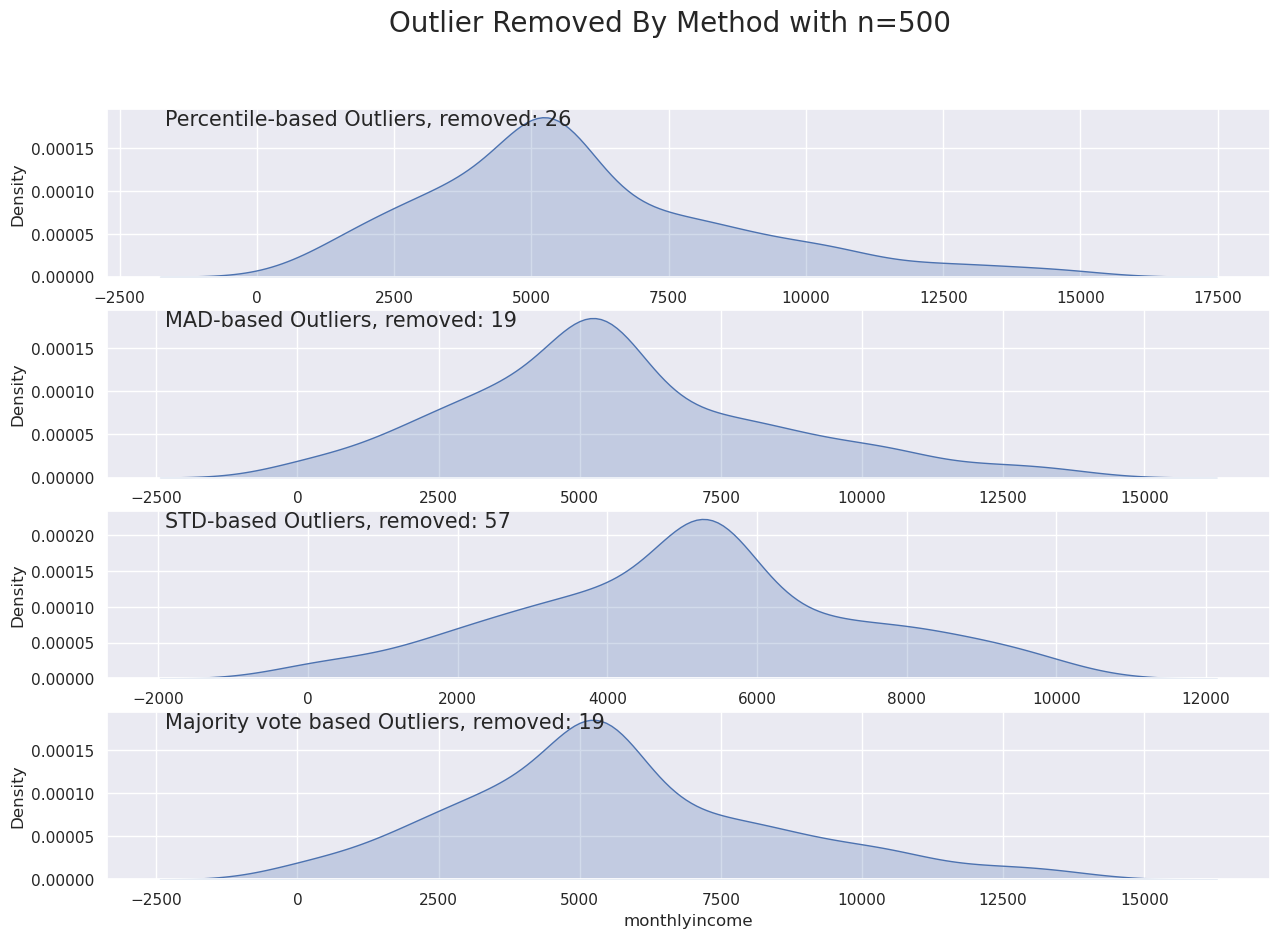

In [84]:
plotOutlierFree(training_data.monthlyincome.sample(500))

In [39]:
# 이상치 데이터를 교체 로직 

def replaceOutlier(data, method=outlierVote, replace='median'):
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['debt', 'outlier'])
    if replace == 'median':
        replace_value = x.debt.median()
    elif replace == 'minUpper':
        replace_value = min([val for (val, vote) in zip(data, vote) if vote])
        if replace_value < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i, 1]: 
            debtNew.append(replace_value)
        else:
            debtNew.append(x.iloc[i, 0])  
    
    return debtNew

In [91]:
incomeNew = replaceOutlier(training_data.monthlyincome, replace='minUpper')

In [89]:
training_data.monthlyincome = incomeNew

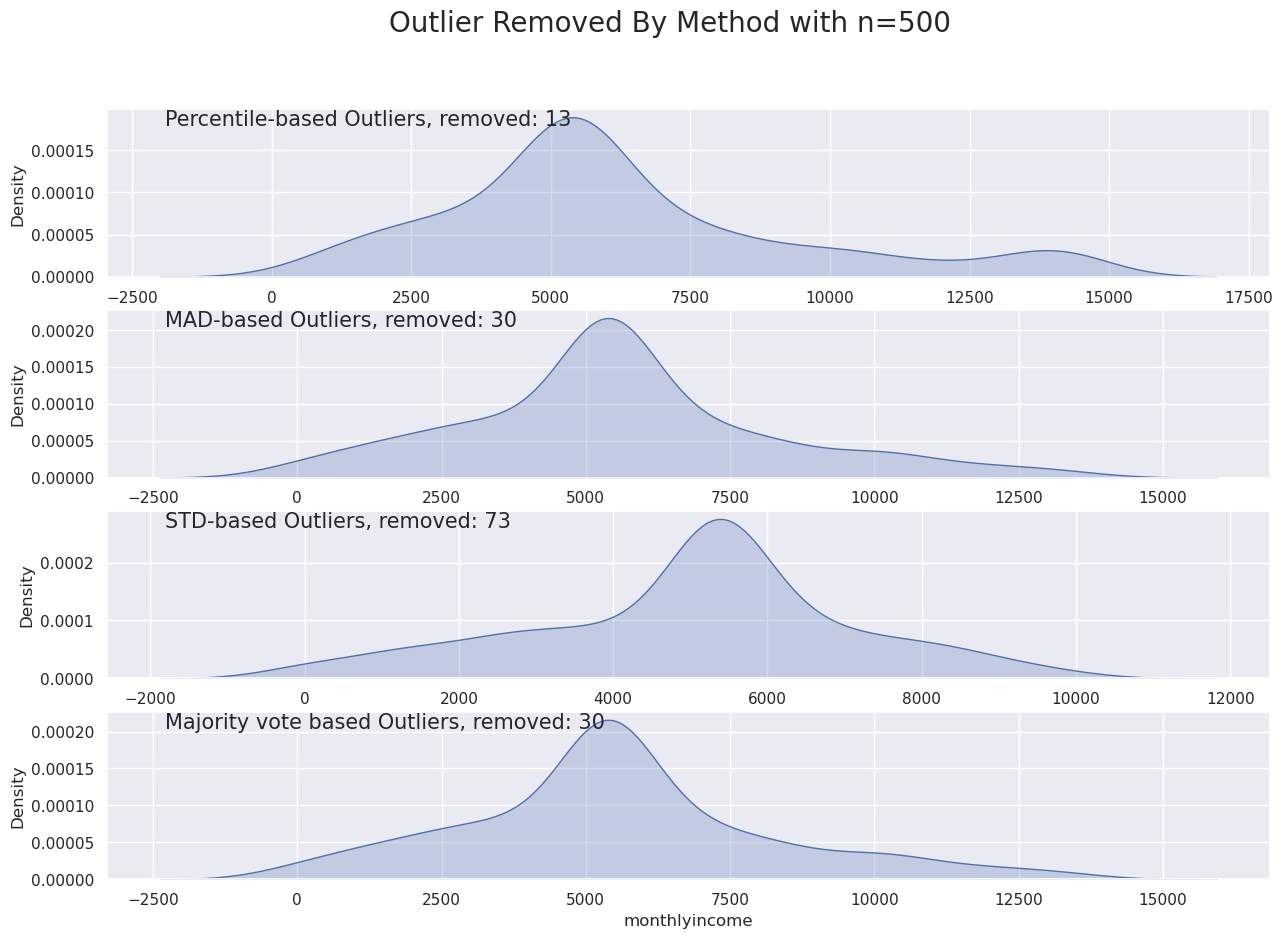

In [90]:
plotOutlierFree(training_data.monthlyincome.sample(500))
# collections.Counter(training_data.numberoftimes90dayslate)

In [43]:
def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

In [44]:
new = removeSpecificAndPutMedian(training_data.numberoftimes90dayslate)

In [45]:
training_data.numberoftimes90dayslate = new

In [46]:
# collections.Counter(training_data.numberrealestateloansorlines)

In [47]:
realNew = []
for val in training_data.numberrealestateloansorlines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)
training_data.numberrealestateloansorlines = realNew

In [48]:
# collections.Counter(training_data.numberoftime6089dayspastduenotworse)

In [49]:
new = removeSpecificAndPutMedian(training_data.numberoftime6089dayspastduenotworse)
training_data.numberoftime6089dayspastduenotworse = new

In [50]:
# collections.Counter(training_data.numberofdependents)

In [51]:
# depNew = []
# for var in training_data.numberofdependents:
#     if var > 10:
#         depNew.append(10)
#     else:
#         depNew.append(var)

In [52]:
# training_data.numberofdependents = depNew

### Feature Importance

In [53]:
training_data.head()

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents
0,1,0.766127,45,2.0,0.802982,9120.0,13,0.0,6,0.0,2.0
1,0,0.957151,40,0.0,0.121876,2600.0,4,0.0,0,0.0,1.0
2,0,0.658180,38,1.0,0.085113,3042.0,2,1.0,0,0.0,0.0
3,0,0.233810,30,0.0,0.036050,3300.0,5,0.0,0,0.0,0.0
4,0,0.907239,49,1.0,0.024926,16867.0,7,0.0,1,0.0,0.0


In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
training_data.columns[1:]

Index(['revolvingutilizationofunsecuredlines', 'age',
       'numberoftime3059dayspastduenotworse', 'debtratio', 'monthlyincome',
       'numberofopencreditlinesandloans', 'numberoftimes90dayslate',
       'numberrealestateloansorlines', 'numberoftime6089dayspastduenotworse',
       'numberofdependents'],
      dtype='object')

In [56]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs

features_label = training_data.columns[1:]

forest = RandomForestClassifier (n_estimators = 10000, random_state=0, n_jobs = -1,max_depth=10)
forest.fit(X,y)
importances = forest.feature_importances_
indices = np. argsort(importances)[::-1]

for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))
    # print (importances[indices[i]])


 1) revolvingutilizationofunsecuredlines 0.293113
 2) age                            0.197075
 3) numberoftime3059dayspastduenotworse 0.140217
 4) debtratio                      0.122855
 5) monthlyincome                  0.056483
 6) numberofopencreditlinesandloans 0.054399
 7) numberoftimes90dayslate        0.049710
 8) numberrealestateloansorlines   0.049088
 9) numberoftime6089dayspastduenotworse 0.020497
10) numberofdependents             0.016564


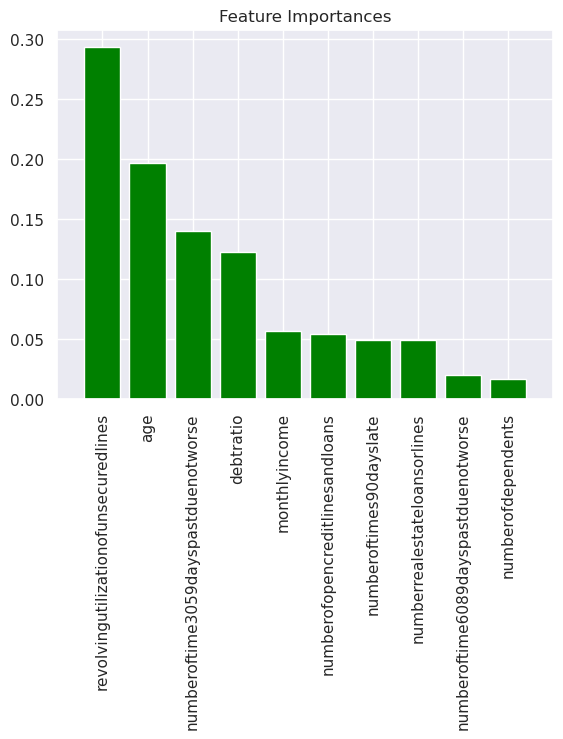

In [57]:
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [58]:


# S3 클라이언트 생성
s3_client = boto3.client('s3')

bucket_ = '4team-637423634530-bucket'
object_ = 'data/preprocessed_data.csv'

# DataFrame -> CSV 
csv_buffer = StringIO()
training_data.to_csv(csv_buffer, index=False)

# 전처리된 데이터를 CSV 파일로 저장한 파일 업로등
s3_client.put_object(Bucket=bucket_, Key=object_, Body=csv_buffer.getvalue())



{'ResponseMetadata': {'RequestId': '1ZJNSMJ1AED3H0P3',
  'HostId': 'jzSbeDcgPTBO7Qi4uCciWkFUeQI4EBZC1H8nB7rP2D5e3DVEd6yNJYn2BTcIJXE/6m+UY0Op1kg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jzSbeDcgPTBO7Qi4uCciWkFUeQI4EBZC1H8nB7rP2D5e3DVEd6yNJYn2BTcIJXE/6m+UY0Op1kg=',
   'x-amz-request-id': '1ZJNSMJ1AED3H0P3',
   'date': 'Fri, 23 Feb 2024 02:59:20 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"045f3b57e17b0fb6718ad51bedf28a09"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"045f3b57e17b0fb6718ad51bedf28a09"',
 'ServerSideEncryption': 'AES256'}

In [59]:
# for i in range(5):
    # print(importances[indices[i]])

# importances[indices] 

In [60]:
# #####학습#####
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)
knMod.fit(X_train, y_train)
######학습#####


KNeighborsClassifier()

In [61]:
# # 모델 아티팩트 로컬에 저장
# joblib.dump(knMod, 'knn_model.pkl')
# bucket_ = '4team-637423634530-bucket'
# key_ = 'data/knn_model.pkl'

# archive_name = 'knn_model.tar.gz'
# # tar.gz 아카이브 생성
# with tarfile.open(archive_name, 'w:gz') as tar:
#     # 모델 데이터 파일 추가
#     tar.add('knn_model.pkl')

# # 모델 악티팩트 S3 에 업로드
# s3_client.upload_file(archive_name, bucket_, key_)


In [62]:
# # 배포 
# sagemaker_session = sagemaker.Session()
# role = sagemaker.get_execution_role()

# container = sagemaker.image_uris.retrieve("knn", boto3.Session().region_name)
# model_arti =f"s3://{bucket_}/{key_}"

# model = sagemaker.model.Model(
#     image_uri=container,
#     model_data=model_arti,
#     role=role
# )

# # 엔드포인트 배포
# # predictor = model.deploy(instance_type='ml.g4dn.xlarge', initial_instance_count=1)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


---